# SED Processing of full CIGALE SED Decomposition fits
This script is used to explore and proccess some of the outputs from the fits files generated by the CIGALE SED decomposition. We intend for this to explore the AGN contribution with a more robust set of tools to see how AGN contamination effects UVJ and other diagnostics.

This script extends the previous script with a full breakdown of the entire ZFOURGE catalogue decomposed SEDS so that a full analysis can be conducted.

In [1]:
# Import all required packages
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath
import seaborn as sns

# refresh

# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

This script is intended to make use of extra fits files provided form ollie to investigate the UVJ diagram.

In particular this is also intended to be used as a stepping stone for the next half of the project.
We will look at quantifying the UVJ points throughout to see how they change with varying parameters.
additionally we may also explore the intermediate type AGN and see how that works.

We will try to find out a way of quantiying the movement with respect to a propgated error and see if we can
make a tool that can be used. 


In [2]:
# In addition also use astSED to create filters

# Read in all filters
# UVJ Filters
pb_U_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.U.dat')
pb_V_path = os.path.join('datasets', 'Filters', 'Generic_Johnson.V.dat')
pb_J_path = os.path.join('datasets', 'Filters', '2MASS_2MASS.J.dat')
# Spitzer filters
pb_f3_6_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I1.dat')
pb_f4_5_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I2.dat')
pb_f5_8_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I3.dat')
pb_f8_0_path = os.path.join('datasets', 'filters', 'Spitzer_IRAC.I4.dat')
# ugr filters
pb_u_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.u_SDSS.dat')
pb_g_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.g_SDSS.dat')
pb_r_path = os.path.join('datasets', 'filters', 'Paranal_OmegaCAM.r_SDSS.dat')


# Load all of the filters 
pb_U = astSED.Passband(pb_U_path, normalise=False)
pb_V = astSED.Passband(pb_V_path, normalise=False)
pb_J = astSED.Passband(pb_J_path, normalise=False)
pb_f3_6 = astSED.Passband(pb_f3_6_path, normalise=False)
pb_f4_5 = astSED.Passband(pb_f4_5_path, normalise=False)
pb_f5_8 = astSED.Passband(pb_f5_8_path, normalise=False)
pb_f8_0 = astSED.Passband(pb_f8_0_path, normalise=False)
pb_u = astSED.Passband(pb_u_path, normalise=False)
pb_g = astSED.Passband(pb_g_path, normalise=False)
pb_r = astSED.Passband(pb_r_path, normalise=False)

filter_set = {'U': pb_U, 'V':pb_V, 'J':pb_J, 'IRAC3.6': pb_f3_6,'IRAC4.5': pb_f4_5,'IRAC5.8': pb_f5_8, 'IRAC8.0':pb_f8_0, 'u': pb_u, 'g': pb_g, 'r':pb_r}



In [3]:
# cosmos_decomposed_df
# uds_decomposed_df
# cdfs_decomposed_df

# # Get all SEDs
# def get_all_seds(path):
#     all_seds = []
#     for file in os.listdir(path):

# What i'll need to do for this is to go through my decomposed dataframes and get the SEDs for each galaxy
# I'll also need to cross check this against the full ZFOURGE files and get the redshift for each
# to ensure they are correctly redshifted to the restframe

In [33]:
#Using the full_CDFS_ids.csv, full_UDS_ids.csv and full_COSMOS_ids.csv files, I can get the redshifts for each galaxy
# Read in each file
# Read in full set 
# full_cdfs_ids = pd.read_csv('datasets/zfourge/full_CDFS_ids.csv')
# full_cosmos_ids = pd.read_csv('datasets/zfourge/full_COSMOS_ids.csv')
full_uds_ids = pd.read_csv('datasets/zfourge/full_UDS_ids.csv')
full_uds_ids

,id,zpk,uv,vj
0,630,0.2673,1.975602,1.567888
1,890,0.3004,1.866688,1.578927
2,1270,0.8056,0.968245,1.047404
3,1271,1.6026,1.391252,1.353639
4,1277,0.3536,1.519229,0.914503
...,...,...,...,...
6783,22073,0.6068,0.784652,0.386038
6784,22077,1.3994,1.166644,1.022200
6785,22078,1.7649,0.676390,0.754626
6786,22086,0.7740,0.809972,0.499669


In [51]:

# Instead we want to use the same methodology as in the eazy extraction
full_zfourge = pd.read_csv('outputs/composite_seds/ZFOURGE_obsevational_composites_fluxesType1AGN.csv')
# drop the uname column
full_zfourge = full_zfourge.drop(columns=['Unnamed: 0'])

# only look at the id and the redshift
full_zfourge = full_zfourge[['id', 'z', 'field']]

# rename the z to zpk
full_zfourge = full_zfourge.rename(columns={'z':'zpk'})


In [52]:
full_zfourge
# drop the prefix with the field title
full_zfourge['id'] = full_zfourge['id'].apply(lambda x: x.split('_')[1])

full_zfourge




# Split into multiple dataframes based on id
full_zfourge_cdfs = full_zfourge[full_zfourge['field'] == 'CDFS']
full_zfourge_cosmos = full_zfourge[full_zfourge['field'] == 'COSMOS']
full_zfourge_uds = full_zfourge[full_zfourge['field'] == 'UDS']

# Reset the index for each
full_zfourge_cdfs = full_zfourge_cdfs.reset_index(drop=True)
full_zfourge_cosmos = full_zfourge_cosmos.reset_index(drop=True)
full_zfourge_uds = full_zfourge_uds.reset_index(drop=True)


In [55]:
full_zfourge_uds

,id,zpk,field
0,10001,1.2255,UDS
1,10004,0.7670,UDS
2,10005,1.4706,UDS
3,10012,1.0971,UDS
4,10013,1.9949,UDS
...,...,...,...
3467,9980,2.4383,UDS
3468,9981,1.0967,UDS
3469,9992,2.2368,UDS
3470,9995,0.7328,UDS


In [56]:

# Using dataframes is wildly inefficient. 
# A most robust approach would be to use only the 2 columns we are interested in, specified in the function call
# and then read these in as numpy arrays


def get_n_seds(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts


In [ ]:
# Get full_zfourge

# create a new function for the useable zfourge ids <- from the useable_zfourge_ids.csv file

def get_n_seds(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())
        
        # Convert to angstroms
        df['wavelength'] = df['wavelength']*10

        if restframe:
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/df['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            df['nuSnu'] = df['Snu']*freq
            # Restframe the values of wavelength
            df['wavelength'] = df['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/df['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            df['Snu'] = df['nuSnu']/freq
            
            # Convert flux values
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            df['Snu'] = df['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            df['Flambda'] = df['Snu']*(3*10**-5)/(df['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # For simplicity, just create some extra columns
        df['lambda (Angstroms)'] = df['wavelength']
        df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(df)
        
        
        plt.loglog(df['wavelength'], df['Flambda'])
    plt.xlabel('Wavelength (Angstroms)')
    plt.ylabel('Flux (Fnu)')
    #plt.xlim(1e3, 1e5)
    plt.ylim(1e-30, 1e-2)
    plt.title('SED of galaxies')
    plt.legend()
    plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts

In [57]:
# Lets read in just one 
full_cdfs_ids = full_zfourge_cdfs
full_cosmos_ids = full_zfourge_cosmos
full_uds_ids = full_zfourge_uds

# print len
print(len(full_cdfs_ids) + len(full_cosmos_ids) + len(full_uds_ids))

11449


In [58]:

gal_field = 'CDFS'
gal_name = '5886'
path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
name = str(gal_name)+'_best_model.fits'

galaxy_path = os.path.join(path, name)
with fits.open(galaxy_path) as data:
    np_arr = np.array(data[1].data)
    #print(data[1].data)
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder())

In [59]:
# np_arr['wavelength']
# np_arr['Fnu']

# df
np_arr
# Define the new dtype with the additional fields
new_dtype_descr = np_arr.dtype.descr + [('Snu', np.float64), ('nuSnu', np.float64), ('Flambda', np.float64) ]
new_dtype = np.dtype(new_dtype_descr)

# Create a new array with the new dtype
new_np_arr = np.zeros(np_arr.shape, dtype=new_dtype)

# Copy over the existing data
for name in np_arr.dtype.names:
    new_np_arr[name] = np_arr[name]

# Add data to the new fields
#new_np_arr['lambda (Angstroms)'] = np_arr['wavelength']
#new_np_arr['Total Flux (erg/s/cm^2/Angstrom)'] = np_arr['Flambda']

# Release the memory of the previous array
del np_arr

# Importantly we only want to read in information from the

In [60]:
new_np_arr

array([(2.10100000e+00, 0.        , 0.00000000e+00, 0., 0., 0., 0., 0., 0., 0.00000000e+00, 0.00000000e+00, 0., 0.,  0.,  0.,         0.        ,  0.00000000e+00, 0., 0., 0., 0., -0., 0., 0., 0.),
       (2.41227076e+00, 0.        , 0.00000000e+00, 0., 0., 0., 0., 0., 0., 0.00000000e+00, 0.00000000e+00, 0., 0.,  0.,  0.,         0.        ,  0.00000000e+00, 0., 0., 0., 0., -0., 0., 0., 0.),
       (2.76965741e+00, 0.        , 0.00000000e+00, 0., 0., 0., 0., 0., 0., 0.00000000e+00, 0.00000000e+00, 0., 0.,  0.,  0.,         0.        ,  0.00000000e+00, 0., 0., 0., 0., -0., 0., 0., 0.),
       ...,
       (2.06265243e+09, 0.00024857, 1.22529350e+20, 0., 0., 0., 0., 0., 0., 6.88335735e+17, 1.21841015e+20, 0., 0., -0., -0., -17893658.48723127, -3.16732286e+09, 0., 0., 0., 0.,  0., 0., 0., 0.),
       (2.08173792e+09, 0.00024877, 1.20387262e+20, 0., 0., 0., 0., 0., 0., 6.76302082e+17, 1.19710960e+20, 0., 0., -0., -0., -17322020.51206618, -3.06613829e+09, 0., 0., 0., 0.,  0., 0., 0., 0.),
   

In [61]:
# A More robust implementation


def get_n_seds_np(df, n, field, restframe=False, all=False):
    # Select n galaxies
    
    df_list = []
    names = []
    redshifts = []
    if all==False:
        selected_galaxies = df.sample(n)
    else: 
        selected_galaxies = df
        
    # Reset the index
    selected_galaxies = selected_galaxies.reset_index(drop=True)
    
    # name 
    gal_name = selected_galaxies['id'].astype(str)
    
    # field
    gal_field = field#selected_galaxies['field'].astype(str)
    
    
    names = gal_field + '_' + gal_name
    gal_redshift = selected_galaxies['zpk'].astype(float)

    # Now we will read in the fits files for these galaxies

    for i in range(len(selected_galaxies)):
        path = 'datasets\\full_zfourge_decomposed\\'+ str(gal_field).lower() +'_best_models_fits\\'
        name = str(gal_name[i])+'_best_model.fits'

        galaxy_path = os.path.join(path, name)
        with fits.open(galaxy_path) as data:
            np_arr_temp = np.array(data[1].data)
            
            # Define the new dtype with the additional fields
            new_dtype_descr = np_arr_temp.dtype.descr + [('Snu', np.float64), ('nuSnu', np.float64), ('Flambda', np.float64) ]
            new_dtype = np.dtype(new_dtype_descr)

            # Create a new array with the new dtype
            np_arr = np.zeros(np_arr_temp.shape, dtype=new_dtype)

            # Copy over the existing data
            for name in np_arr_temp.dtype.names:
                np_arr[name] = np_arr_temp[name]
                
            del np_arr_temp # Release the memory of the previous array

            
            # Release the memory of the previous array
            
        
        # Convert to angstroms
        np_arr['wavelength'] = np_arr['wavelength']*10

        if restframe:
            np_arr['Snu'] = np_arr['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            # F_nu currently has a frequency dependence, convert to nuFnu by multiplying the the frequency associated
            # with the wavelength, as we are in angstroms, we can use the formula c = f*lambda
            
            
            # This should prevent any issues, but check
            freq = (3*10**18)/np_arr['wavelength'] # in Hz
            # multiply the Snu * nu to get nuSnu
            np_arr['nuSnu'] = np_arr['Snu']*freq
            # Restframe the values of wavelength
            np_arr['wavelength'] = np_arr['wavelength'] / (1 + gal_redshift[i]) # we redshift the values of of wavelength
            # now calculate a new frequency, based on the new wavelength
            freq = (3*10**18)/np_arr['wavelength'] # in Hz
            # divide the nuSnu by the new frequency to get the restframed values
            np_arr['Snu'] = np_arr['nuSnu']/freq
            
            # Convert flux values
            np_arr['Flambda'] = np_arr['Snu']*(3*10**-5)/(np_arr['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        else:
            # Convert flux values
            np_arr['Snu'] = np_arr['Fnu']*10**-3 # milliJanksys to Janksys <- J = ergs/(s*(cm^2)*(s^-1))
            np_arr['Flambda'] = np_arr['Snu']*(3*10**-5)/(np_arr['wavelength']**2) # S_nu to F_lambda <- angstroms 
            
        
            
            
        redshift_Val = gal_redshift[i]
        redshifts.append(redshift_Val)        
        
        

        
        # # For simplicity, just create some extra columns
        # df['lambda (Angstroms)'] = df['wavelength']
        # df['Total Flux (erg/s/cm^2/Angstrom)'] = df['Flambda']
        
        
        
        df_list.append(np_arr)
        
        
    #     plt.loglog(np_arr['wavelength'], np_arr['Flambda'])
    # plt.xlabel('Wavelength (Angstroms)')
    # plt.ylabel('Flux (Fnu)')
    # #plt.xlim(1e3, 1e5)
    # plt.ylim(1e-30, 1e-2)
    # plt.title('SED of galaxies')
    # plt.legend()
    # plt.show()
    
    print(len(df_list))
    
    return df_list, names, redshifts


In [63]:
# Try optimised version of code

# CDFS
cdfs_seds, cdfs_names, cdfs_redshifts = get_n_seds_np(full_zfourge_cdfs, 500, 'CDFS', restframe=True, all=True)

# COSMOS
cosmos_seds, cosmos_names, cosmos_redshifts = get_n_seds_np(full_zfourge_cosmos, 500, 'COSMOS', restframe=True, all=True)

# UDS
uds_seds, uds_names, uds_redshifts = get_n_seds_np(full_zfourge_uds, 500, 'UDS', restframe=True, all=True)


4022
3955
3472


In [65]:
master_seds = []

master_seds.extend(cdfs_seds)
master_seds.extend(cosmos_seds)
master_seds.extend(uds_seds)

In [69]:
# Check the length
len(master_seds)

11449

In [70]:
all_names = cdfs_names
all_names



0       CDFS_10005
1       CDFS_10011
2       CDFS_10028
3       CDFS_10029
4       CDFS_10032
           ...    
4017     CDFS_9974
4018     CDFS_9975
4019     CDFS_9978
4020     CDFS_9983
4021     CDFS_9994
Name: id, Length: 4022, dtype: object

In [71]:
# add the next set of names
all_names = all_names.append(cosmos_names)
all_names = all_names.append(uds_names)

len(all_names)

11449

In [72]:
# reset the index
all_names = all_names.reset_index(drop=True)

In [73]:
# Do the same thing for redshifts
all_redshifts = cdfs_redshifts
len(all_redshifts)


all_redshifts.extend(cosmos_redshifts)
len(all_redshifts)

all_redshifts.extend(uds_redshifts)
len(all_redshifts)


11449

In [74]:
# reset indicies
all_names = all_names.reset_index(drop=True)

all_names

0        CDFS_10005
1        CDFS_10011
2        CDFS_10028
3        CDFS_10029
4        CDFS_10032
            ...    
11444      UDS_9980
11445      UDS_9981
11446      UDS_9992
11447      UDS_9995
11448      UDS_9998
Name: id, Length: 11449, dtype: object

In [77]:
# Check the length of all master 
mas= len(master_seds)
nam = len(all_names)
z= len(all_redshifts)

# print
print(mas, nam, z)

11449 11449 11449


In [79]:
# No we can do some more analysis
# export_df = pd.DataFrame(columns=['ID', 'UV', 'VJ', 'zpk'])



In [80]:
# Create a composite set using the master_seds
#uv_0, vj_0 = generate_UVJ_composite_set_colours_np([master_seds], [0], pb_U, pb_V, pb_J)

In [81]:
# uv = uv_0[0]
# vj = vj_0[0]

In [82]:
len(master_seds)

11449

In [20]:
# export_df['ID'] = all_names
# export_df['UV'] = uv
# export_df['VJ'] = vj
# export_df['zpk'] = all_redshifts

In [83]:
# export_df

In [84]:

def plot_uvj_nocategorise(df, x, y):
    plt.figure(figsize=(6, 6))

    xmax = 2.2
    ymax = 2.5
    xmin = -0.5
    ymin = 0

    # Set the plotting limits
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    # Define the points for a quiescent galaxy selection
    x_points = [-0.5, 0.85, 1.6, 1.6]
    y_points = [1.3, 1.3, 1.95, 2.5]

    # Plot the points
    plt.plot(x_points, y_points, linestyle='-')

    # as all the points have associated names, plot the names
    #for i, txt in enumerate(df['ID']):
    #    plt.annotate(txt, (x[i], y[i]))
        


    # Interpolate the y-value at x=1.2
    x_target = 1.2
    y_target = np.interp(x_target, x_points, y_points)

    # Plot the interpolated point, this separates everything on the right as dusty galaxies,
    # and everything on the left as star-forming galaxies
    plt.plot([x_target, x_target], [0, y_target], linestyle='--')

    quiescent_x = [-0.5, 0.85, 1.6, 1.6, xmin, xmin]
    quiescent_y = [1.3, 1.3, 1.95, 2.5, ymax, 1.3]
    # We want to make a wedge selection for the Quiescent Selection of Galaxies
    points = np.column_stack([x, y])
    verts = np.array([quiescent_x, quiescent_y]).T
    path = mpath.Path(verts)


    # Define the path for point selection
    #selected_path = mpath.Path([(2, 3), (6, 4), (8, 2), (2, 1), (2, 3)])  # Example path, replace with your own

    # Use path.contains_points to get a boolean array
    points_inside_selection = path.contains_points(np.column_stack([x, y]))



    dusty_condition = (points[:, 0] > x_target) & (~points_inside_selection)
    star_forming_condition = (points[:, 0] < x_target) & (~points_inside_selection)



    # Filter the DataFrame using the boolean array
    selected_df = df[points_inside_selection] # For quiescent, clean later



    # Sort the quiescent and non-quiescent galaxies
    quiescent_points = points[path.contains_points(points)]
    # Find the points from here to categorise dusty, and star-forming galaxies
    non_quiescent_points = points[~path.contains_points(points)]
    dusty_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] > x_target]
    star_forming_galaxies_points = non_quiescent_points[non_quiescent_points[:, 0] < x_target]



    # print the number of galaxies that are in each category
    print(f'Number of Quiescent Galaxies: {len(quiescent_points)}')
    print(f'Number of Dusty Galaxies: {len(dusty_galaxies_points)}')
    print(f'Number of Star Forming Galaxies: {len(star_forming_galaxies_points)}')
    
    #print(non_quiescent_points[0][0])

    #print(y)
    # Plot the selected points
    #plt.scatter(x, y, s=3, alpha=0.5, label='Not Quiescent Selection')
    plt.scatter(quiescent_points[:, 0], quiescent_points[:, 1], c='r', s=3, alpha=0.5, label='Quiescent Selection')
    plt.scatter(dusty_galaxies_points[:, 0], dusty_galaxies_points[:, 1], c='g', s=3, alpha=0.5, label='Dusty Galaxies')
    plt.scatter(star_forming_galaxies_points[:, 0], star_forming_galaxies_points[:, 1], c='b', s=3, alpha=0.5, label='Star Forming Galaxies')

    plt.xlabel('Restframe V-J [Mag]')
    plt.ylabel('Restframe U-V [Mag]')
    plt.title('UVJ Diagram for the all fields')
    plt.legend()
    plt.show()

In [85]:
#plot_uvj_nocategorise(export_df, export_df['VJ'], export_df['UV'])

In [25]:
# Create a dictionary to store the info related to the seds: should be name, 'id', 'z', 'sed'

sed_dict = {'id': [], 'z': [], 'sed': []}


In [86]:

# We will need to create a function that use the decomp, performing an analysis on the SEDs
# We can try wrapping the np arrays in a pandas dataframe,
def decompose_agn_seds(best_fit_seds):
    # Create a list to store the decomposed SEDs
    decomposed_seds = []
    
    # Iterate through the best_fit_seds
    for i in range(len(best_fit_seds)):
        # Create a dataframe from the best_fit_seds
        sed_df = pd.DataFrame(best_fit_seds[i]) # Creates a dataframe from the numpy array
        
        
        new_df = sed_df.copy()
        
        # Drop the zero values - maybe include this potentially
       # new_df = df[df['L_lambda_total'] > 10**-7].copy()

        # AGN components - Remove the galaxy component
        # Create an adjust L_lambda to plot against
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total']

        # Remove the young and old stellar components
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['stellar.old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['stellar.young']


        # Remove the absopriton and emission lines

        # Absorption
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.absorption_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.absorption_young']

        # Emission
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.lines_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.lines_young']


        # Removing the dust component
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['dust']


        # Removing the galactic continuum
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.continuum_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['nebular.continuum_young']

        # Removing the attentuated components
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.stellar.old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.stellar.young']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.lines_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.lines_young']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.continuum_old']
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['attenuation.nebular.continuum_young']


        # Remove the igm
        new_df['L_lambda_total_decomposed_AGN'] = new_df['L_lambda_total_decomposed_AGN'] - new_df['igm']
        
        integral_total = np.trapz(new_df['L_lambda_total'], new_df['wavelength'])
        integral_decomposed = np.trapz(new_df['L_lambda_total_decomposed_AGN'], new_df['wavelength'])

        # Scaling factor
        scaling_factor = integral_total/integral_decomposed

        # Normalise the decomposed values <- Unsure if we should be doing this, but for complenetess it may be a good idea
        new_df['L_lambda_total_decomposed_AGN_Scaled'] = new_df['L_lambda_total_decomposed_AGN'] * scaling_factor
        
        

        # Galaxy component - Remove the AGN Component
        # Create an adjust L_lambda to plot against
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total']

        # To ensure this is done correctly, we also are choosing to consider simply just the AGN components 
        # where the the values are within a range of 10^2 - 10^7
        new_df = new_df[(new_df['wavelength'] > 10**-2) & (new_df['wavelength'] < 10**7)]

        # We would like to remove the AGN from the galaxy if possible

        # Removing polar dust
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_polar_dust']

        # Removing torus
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_torus']

        # Removing the accretion disk
        new_df['L_lambda_total_decomposed'] = new_df['L_lambda_total_decomposed'] - new_df['agn.SKIRTOR2016_disk']

        # normalise the values using the integral of the total flux of the original SED
        # We will use the trapezoidal rule to calculate the integral of the total flux
        # We will then divide the decomposed values by this integral to normalise the values
        integral_total = np.trapz(new_df['L_lambda_total'], new_df['wavelength'])
        integral_decomposed = np.trapz(new_df['L_lambda_total_decomposed'], new_df['wavelength'])

        # Scaling factor
        scaling_factor = integral_total/integral_decomposed

        # Normalise the decomposed values <- Unsure if we should be doing this, but for complenetess it may be a good idea
        new_df['L_lambda_total_decomposed_Scaled'] = new_df['L_lambda_total_decomposed'] * scaling_factor
        
        # Add the values to the dictionary
        # sed_dict['id'].append(all_names[i])
        # sed_dict['z'].append(all_redshifts[i])
        # sed_dict['sed'].append(new_df)        
        
        
        # Append the decomposed SED to the decomposed_seds list
        decomposed_seds.append(new_df)
        
    return decomposed_seds 




In [87]:
# This potentially will be bad for memory but have a look



decomposed_seds = decompose_agn_seds(master_seds)

In [90]:
len(decomposed_seds)
len(all_names)
len(all_redshifts)

11449

In [91]:
decomposed_seds[0]

,wavelength,Fnu,L_lambda_total,stellar.old,stellar.young,nebular.absorption_old,nebular.absorption_young,nebular.lines_old,nebular.lines_young,nebular.continuum_old,...,agn.SKIRTOR2016_polar_dust,agn.SKIRTOR2016_disk,igm,Snu,nuSnu,Flambda,L_lambda_total_decomposed_AGN,L_lambda_total_decomposed_AGN_Scaled,L_lambda_total_decomposed,L_lambda_total_decomposed_Scaled
0,1.000000e+01,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,0.0,0.0,-0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
1,1.148154e+01,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,0.0,0.0,-0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
2,1.318257e+01,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,0.0,0.0,-0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
3,1.513561e+01,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,0.0,0.0,-0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
4,1.737801e+01,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000e+00,...,0.0,0.0,-0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3529,9.638000e+06,0.003677,3.450821e+27,0.0,0.0,0.0,0.0,47.072194,10663.451951,4.204249e+23,...,0.0,0.0,0.0,0.000001,415051.954387,4.306412e-25,2.598839e+11,-1.472622e+28,3.450821e+27,3.450821e+27
3530,9.727000e+06,0.003555,3.276216e+27,0.0,0.0,0.0,0.0,46.480964,10529.518133,4.134126e+23,...,0.0,0.0,0.0,0.000001,397689.824615,4.088515e-25,-3.381422e+11,1.916069e+28,3.276216e+27,3.276216e+27
3531,9.772370e+06,0.003497,3.192321e+27,0.0,0.0,0.0,0.0,46.179569,10461.241984,4.099073e+23,...,0.0,0.0,0.0,0.000001,389313.582664,3.983820e-25,8.171356e+10,-4.630266e+27,3.192321e+27,3.192321e+27
3532,9.817000e+06,0.003437,3.109805e+27,0.0,0.0,0.0,0.0,45.883090,10394.079442,4.065033e+23,...,0.0,0.0,0.0,0.000001,380982.501429,3.880844e-25,4.557477e+11,-2.582476e+28,3.109805e+27,3.109805e+27


In [92]:
uv_galaxy_colours = []
vj_galaxy_colours = []
uv_full_colours = []
vj_full_colours = []



# Instead of doing it this way we will calculate the individual magnitudes
u_mags_full = []
v_mags_full = []
j_mags_full = []

u_mags_galaxy = []
v_mags_galaxy = []
j_mags_galaxy = []


ug_galaxy_colours = []
gr_galaxy_colours = []

ug_full_colours = []
gr_full_colours = []




for i, sed_data in enumerate(decomposed_seds):
    
    # Create an SED object using astSED - for the decomposed galaxy component (UVJ)
    wl = sed_data['wavelength']
    fl = sed_data['L_lambda_total_decomposed']  
    sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)    
    try:
        u = astSED.SED.calcMag(sed, pb_U, magType='AB')
        v = astSED.SED.calcMag(sed, pb_V, magType='AB')
        j = astSED.SED.calcMag(sed, pb_J, magType='AB')
        
    except:
        u = np.nan
        v = np.nan
        j = np.nan
        
    # Append colours to list
    u_mags_galaxy.append(u)
    v_mags_galaxy.append(v)
    j_mags_galaxy.append(j)
    
    
    
    
    # Create an SED object using astSED - for full colours 
    wl = sed_data['wavelength']
    fl = sed_data['L_lambda_total']
    sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)    
    try:
        # uv = astSED.SED.calcColour(sed, pb_U, pb_V, magType='AB')
        # vj = astSED.SED.calcColour(sed, pb_V, pb_J, magType='AB')
        u = astSED.SED.calcMag(sed, pb_U, magType='AB')
        v = astSED.SED.calcMag(sed, pb_V, magType='AB')
        j = astSED.SED.calcMag(sed, pb_J, magType='AB')
        
    except:
        u = np.nan
        v = np.nan
        j = np.nan
        
    # Append colours to list
    u_mags_full.append(u)
    v_mags_full.append(v)
    j_mags_full.append(j)
    
    
    
    
    # This doesn't work so we can ignore this
    
    
#     # In addition to this we would also like to calculate the ug and gr colours
#     # Note that we need to need to redshift the sed <- 
#     # Decomposed first
#     wl = sed_data['wavelength']
#     fl = sed_data['L_lambda_total_decomposed']
#     sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)
#     # redshift
#     sed.redshift(all_redshifts[i])
#     try:
#         ug = astSED.SED.calcColour(sed, pb_u, pb_g, magType='AB')
#         gr = astSED.SED.calcColour(sed, pb_g, pb_r, magType='AB')
#     except:
#         ug = np.nan
#         gr = np.nan
#     ug_galaxy_colours.append(ug)
#     gr_galaxy_colours.append(gr)
    
    
    
#     # now for the full colours
#     wl = sed_data['wavelength']
#     fl = sed_data['L_lambda_total']
#     sed = astSED.SED(wavelength=wl, flux=fl, z=0.0)
#     # redshift
#     sed.redshift(all_redshifts[i])
#     try:
#         ug = astSED.SED.calcColour(sed, pb_u, pb_g, magType='AB')
#         gr = astSED.SED.calcColour(sed, pb_g, pb_r, magType='AB')
#     except:
#         ug = np.nan
#         gr = np.nan
#     ug_full_colours.append(ug)
#     gr_full_colours.append(gr)
    
# # Add the colours to the export_df

    

In [93]:
# To ensure we can do quick an speedy data analysis we will create a new dataframe: 
# it will contain the full UVJ colours, the decomposed UVJ colours, and the redshifts, and the names of the galaxies
decomposed_df = pd.DataFrame(columns=['ID', 'U_Full', 'V_Full','J_Full', 'U_Decomposed', 'V_Decomposed','J_Decomposed',  'zpk'])

decomposed_df['ID'] = all_names

# UVJ colours
decomposed_df['U_Full'] = u_mags_full
decomposed_df['V_Full'] = v_mags_full
decomposed_df['J_Full'] = j_mags_full
decomposed_df['U_Decomposed'] = u_mags_galaxy
decomposed_df['V_Decomposed'] = v_mags_galaxy
decomposed_df['J_Decomposed'] = j_mags_galaxy


# redshifts
decomposed_df['zpk'] = all_redshifts

# Save and output this as a csv to be used later in full_zfourge_decomposed
decomposed_df.to_csv('datasets/full_zfourge_decomposed/decomposed_colours.csv', index=False)



In [94]:
print(len(uv_full_colours))


print(len(vj_full_colours))

print(len(uv_galaxy_colours))
print(len(vj_galaxy_colours))

# # Print the ugr
# print(len(ug_full_colours))
# print(len(gr_full_colours))

# print(len(ug_galaxy_colours))
# print(len(gr_galaxy_colours))

# and redshift
print(len(all_names))



11449
11449
11449
11449
11449
11449
11449
11449
11449


In [95]:
# We can now read in the decomposed colours and perform some analysis on them
decomposed_df = pd.read_csv('datasets/full_zfourge_decomposed/decomposed_colours.csv')


In [96]:
decomposed_df

,ID,UV_Full,VJ_Full,UV_Decomposed,VJ_Decomposed,zpk,UG_Full,GR_Full,UG_Decomposed,GR_Decomposed
0,CDFS_10005,0.910699,0.733106,0.910699,0.733106,1.7572,0.329656,0.264762,0.329656,0.264762
1,CDFS_10011,1.380354,0.863838,1.380354,0.863838,0.7800,0.048676,0.632581,0.048676,0.632581
2,CDFS_10028,0.443387,0.203338,0.443382,0.203213,1.3215,0.065890,-0.044862,0.065889,-0.044868
3,CDFS_10029,0.910699,0.733106,0.910699,0.733106,1.1036,0.238083,0.252295,0.238083,0.252295
4,CDFS_10032,1.296815,0.850163,1.373219,0.859937,1.0506,0.058645,0.362414,-0.002430,0.338892
...,...,...,...,...,...,...,...,...,...,...
11444,UDS_9980,0.498417,0.414585,0.509884,0.225754,2.4383,0.614829,0.133008,0.558263,0.016816
11445,UDS_9981,0.672092,0.387498,0.672092,0.387498,1.0967,0.010759,0.056136,0.010759,0.056136
11446,UDS_9992,0.495456,0.241327,0.509884,0.225754,2.2368,0.369394,0.068396,0.357596,0.052881
11447,UDS_9995,0.509884,0.225754,0.509884,0.225754,0.7328,-0.033343,0.241050,-0.033343,0.241050


In [30]:
# plt.figure(figsize=(6, 6))

# xmax = 2.2
# ymax = 2.5
# xmin = -0.5
# ymin = 0


# # Set the plotting limits
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)





# # Define the points for a quiescent galaxy selection
# x_points = [-0.5, 0.85, 1.6, 1.6]
# y_points = [1.3, 1.3, 1.95, 2.5]
# # Plot the points
# plt.plot(x_points, y_points, linestyle='-')

# # as all the points have associated names, plot the names
# #for i, txt in enumerate(df['ID']):
# #    plt.annotate(txt, (x[i], y[i]))
    
# # plot the points
# plt.scatter(vj_full_colours, uv_full_colours, s=3, alpha=0.5, label='Galaxies (with AGN)')

# plt.scatter(vj_galaxy_colours, uv_galaxy_colours, s=3, alpha=0.5, label='Galaxies (No AGN)')


# # Adding an arrow from the full galaxy to the decomposed galaxy
# for i in range(len(vj_full_colours)): 
#     plt.arrow(vj_full_colours[i], uv_full_colours[i], vj_galaxy_colours[i] - vj_full_colours[i], uv_galaxy_colours[i] - uv_full_colours[i], head_width=0.025, head_length=0.05, fc='k', ec='k')


# # Interpolate the y-value at x=1.2
# x_target = 1.2
# y_target = np.interp(x_target, x_points, y_points)

# # Plot the interpolated point, this separates everything on the right as dusty galaxies,
# # and everything on the left as star-forming galaxies
# plt.plot([x_target, x_target], [0, y_target], linestyle='--')

# plt.xlabel('Restframe V-J [Mag]')
# plt.ylabel('Restframe U-V [Mag]')
# plt.title('UVJ Diagram for the all fields')
# plt.legend()
# plt.savefig('outputs/UVJ_Diagram_with_AGN_decom_Allfields.png')
# plt.show()

Average VJ Full: 0.571142364258098Average UV Full: 0.8033837895213408Average VJ Galaxy: 0.5530569448836657Average UV Galaxy: 0.8369183559234372


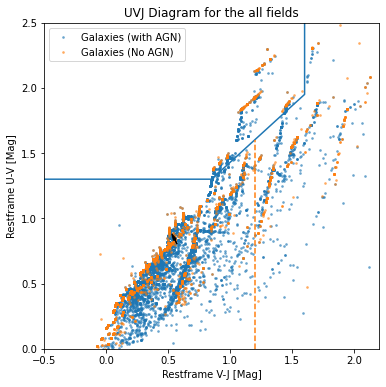

In [97]:

uv_full_colours = decomposed_df['U_Full'] - decomposed_df['V_Full']
vj_full_colours = decomposed_df['V_Full'] - decomposed_df['J_Full']

uv_galaxy_colours = decomposed_df['U_Decomposed'] - decomposed_df['V_Decomposed']
vj_galaxy_colours = decomposed_df['V_Decomposed'] - decomposed_df['J_Decomposed']


# Try an average approach 
plt.figure(figsize=(6, 6))

xmax = 2.2
ymax = 2.5
xmin = -0.5
ymin = 0


# Set the plotting limits
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)





# Define the points for a quiescent galaxy selection
x_points = [-0.5, 0.85, 1.6, 1.6]
y_points = [1.3, 1.3, 1.95, 2.5]
# Plot the points
plt.plot(x_points, y_points, linestyle='-')

# as all the points have associated names, plot the names
#for i, txt in enumerate(df['ID']):
#    plt.annotate(txt, (x[i], y[i]))
    
# plot the points
plt.scatter(vj_full_colours, uv_full_colours, s=3, alpha=0.5, label='Galaxies (with AGN)')

plt.scatter(vj_galaxy_colours, uv_galaxy_colours, s=3, alpha=0.5, label='Galaxies (No AGN)')


# Instead of plotting all arrows, define an average arrow 
# we want to get the average location of each set of points, and plot the transition

# Drop any and all nan values, if they exist, drop the corresponding values in the other list
vj_full_colours = np.array(vj_full_colours)
uv_full_colours = np.array(uv_full_colours)

vj_galaxy_colours = np.array(vj_galaxy_colours)
uv_galaxy_colours = np.array(uv_galaxy_colours)


# Remove nan values
vj_full_colours = vj_full_colours[~np.isnan(vj_full_colours)]
uv_full_colours = uv_full_colours[~np.isnan(uv_full_colours)]

vj_galaxy_colours = vj_galaxy_colours[~np.isnan(vj_galaxy_colours)]
uv_galaxy_colours = uv_galaxy_colours[~np.isnan(uv_galaxy_colours)]


# Get the average location of each set of points
avg_vj_full = np.mean(vj_full_colours)
avg_uv_full = np.mean(uv_full_colours)

avg_vj_galaxy = np.mean(vj_galaxy_colours)
avg_uv_galaxy = np.mean(uv_galaxy_colours)


print(f'Average VJ Full: {avg_vj_full}'
      f'Average UV Full: {avg_uv_full}'
      f'Average VJ Galaxy: {avg_vj_galaxy}'
      f'Average UV Galaxy: {avg_uv_galaxy}')

# Plot the average arrow
plt.arrow(avg_vj_full, avg_uv_full, avg_vj_galaxy - avg_vj_full, avg_uv_galaxy - avg_uv_full, head_width=0.025, head_length=0.05, fc='k', ec='k')



# Interpolate the y-value at x=1.2
x_target = 1.2
y_target = np.interp(x_target, x_points, y_points)

# Plot the interpolated point, this separates everything on the right as dusty galaxies,
# and everything on the left as star-forming galaxies
plt.plot([x_target, x_target], [0, y_target], linestyle='--')

plt.xlabel('Restframe V-J [Mag]')
plt.ylabel('Restframe U-V [Mag]')
plt.title('UVJ Diagram for the all fields')
plt.legend()
plt.savefig('outputs/UVJ_Diagram_with_AGN_decom_Allfields_Avg.png')
plt.show()

In [32]:
# # Explore the differences between the two sets of colours only for values greater than uv = 1 and uv = 1
# plt.figure(figsize=(6, 6))

# xmax = 2.2
# ymax = 2.5
# xmin = -0.5
# ymin = 0


# # Set the plotting limits
# plt.xlim(xmin, xmax)
# plt.ylim(ymin, ymax)





# # Define the points for a quiescent galaxy selection
# x_points = [-0.5, 0.85, 1.6, 1.6]
# y_points = [1.3, 1.3, 1.95, 2.5]
# # Plot the points
# plt.plot(x_points, y_points, linestyle='-')

# # as all the points have associated names, plot the names
# #for i, txt in enumerate(df['ID']):
# #    plt.annotate(txt, (x[i], y[i]))
    
# # plot the points
# plt.scatter(vj_full_colours, uv_full_colours, s=3, alpha=0.5, label='Galaxies (with AGN)')

# plt.scatter(vj_galaxy_colours, uv_galaxy_colours, s=3, alpha=0.5, label='Galaxies (No AGN)')


# # Instead of plotting all arrows, define an average arrow 
# # we want to get the average location of each set of points, and plot the transition

# # Drop any and all nan values, if they exist, drop the corresponding values in the other list
# vj_full_colours = np.array(vj_full_colours)
# uv_full_colours = np.array(uv_full_colours)

# vj_galaxy_colours = np.array(vj_galaxy_colours)
# uv_galaxy_colours = np.array(uv_galaxy_colours)

# # We want a condition where the UV values are greater than 1 and the VJ values are greater than 1
# # Ensuring the the UV and VJ values that correspond to each set are both greater than 1 at each idnex
# # We can then use this to filter the values
# condition_full = (uv_full_colours < 1) & (vj_full_colours < 1)

# condition_galaxy = (uv_galaxy_colours < 1) & (vj_galaxy_colours < 1)

# # Filter the values
# vj_full_colours_temp = vj_full_colours[~condition_full]
# uv_full_colours_temp = uv_full_colours[~condition_full]

# vj_galaxy_colours_temp = vj_galaxy_colours[~condition_galaxy]
# uv_galaxy_colours_temp = uv_galaxy_colours[~condition_galaxy]



# # Remove nan values
# vj_full_colours_temp = vj_full_colours_temp[~np.isnan(vj_full_colours)]
# uv_full_colours_temp = uv_full_colours_temp[~np.isnan(uv_full_colours)]

# vj_galaxy_colours_temp = vj_galaxy_colours_temp[~np.isnan(vj_galaxy_colours)]
# uv_galaxy_colours_temp = uv_galaxy_colours_temp[~np.isnan(uv_galaxy_colours)]


# # Get the average location of each set of points
# avg_vj_full = np.mean(vj_full_colours_temp)
# avg_uv_full = np.mean(uv_full_colours_temp)

# avg_vj_galaxy = np.mean(vj_galaxy_colours_temp)
# avg_uv_galaxy = np.mean(uv_galaxy_colours_temp)


# print(f'Average VJ Full: {avg_vj_full}'
#       f'Average UV Full: {avg_uv_full}'
#       f'Average VJ Galaxy: {avg_vj_galaxy}'
#       f'Average UV Galaxy: {avg_uv_galaxy}')

# # Plot the average arrow
# plt.arrow(avg_vj_full, avg_uv_full, avg_vj_galaxy - avg_vj_full, avg_uv_galaxy - avg_uv_full, head_width=0.025, head_length=0.05, fc='k', ec='k')



# # Interpolate the y-value at x=1.2
# x_target = 1.2
# y_target = np.interp(x_target, x_points, y_points)

# # Plot the interpolated point, this separates everything on the right as dusty galaxies,
# # and everything on the left as star-forming galaxies
# plt.plot([x_target, x_target], [0, y_target], linestyle='--')

# plt.xlabel('Restframe V-J [Mag]')
# plt.ylabel('Restframe U-V [Mag]')
# plt.title('UVJ Diagram for the all fields')
# plt.legend()
# # plt.savefig('outputs/UVJ_Diagram_with_AGN_decom_Allfields_Avg_subset.png')
# plt.show()